In [1]:
# https://www.youtube.com/watch?v=bANQk--Maxs
# https://lmstudio.ai/

# pip install langchain-openai
# pip install ultralytics
# pip install ultralytics
# pip install dotenv
# pip install yaml
# pip install langchain
 
# python > 3.10

# LM Studio 서버 구동 후

import yaml
from langchain_openai import ChatOpenAI
from langchain_core.callbacks.streaming_stdout import StreamingStdOutCallbackHandler
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser
from ultralytics import YOLO
import cv2, json
from IPython.display import display
from PIL import Image
import warnings
import dotenv
from langchain.schema.runnable import RunnablePassthrough

# 경고 메시지 무시 및 환경변수 로드
dotenv.load_dotenv()
warnings.filterwarnings("ignore")

In [4]:
img_path = "/Users/jini/Downloads/jini/강의/3_애드인에듀/애드인에듀_동서대학교(301)/ready/py39/v9_yolo_gpt/input.png"
frame = cv2.imread(img_path)
if frame is None:
    raise FileNotFoundError(f"이미지를 찾을 수 없습니다: {img_path}")

frame = cv2.resize(frame, (1200, 800))
results = YOLO("./yolo11n.pt")(source=frame, conf=0.5, verbose=False)


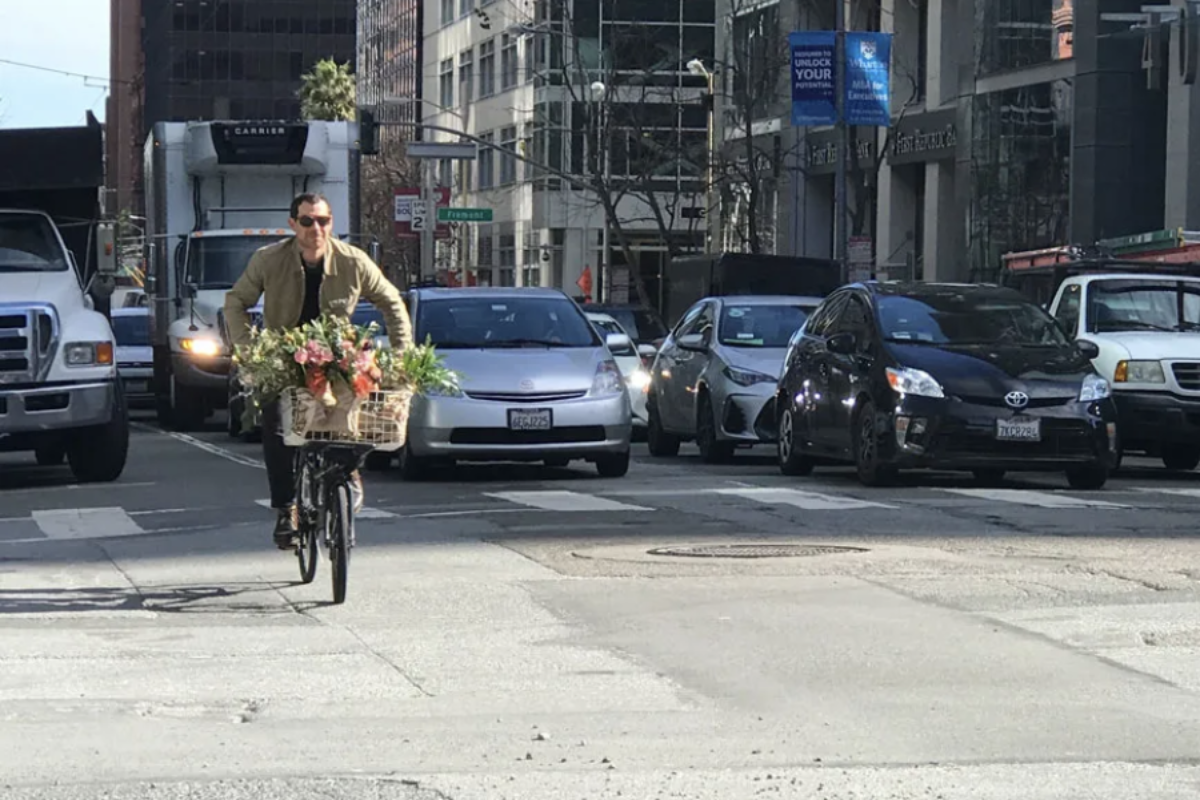

In [5]:
display(Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)))

In [6]:
results

[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted p

In [7]:
with open("/Users/jini/Downloads/jini/강의/3_애드인에듀/애드인에듀_동서대학교(301)/ready/py39/v9_yolo_gpt/prompt2.yaml", "r", encoding="utf-8") as f:
    cfg = yaml.safe_load(f)
template_str = cfg["template"]

In [8]:
llm = ChatOpenAI(
    base_url="http://localhost:1234/v1",
    api_key="lm-studio",
    model="qwen2.5-7b-instruct-kowiki-qa",
    streaming=True,
    callbacks=[StreamingStdOutCallbackHandler()]
)

In [9]:
prompt = PromptTemplate.from_template(template_str)
chain = (
    {"info": RunnablePassthrough(), "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

In [10]:
info = {}
annot = frame.copy()
for res in results:
    for b in res.boxes:
        cls   = int(b.cls[0].item())
        label = res.names.get(cls, str(cls))
        x1,y1,x2,y2 = map(int, b.xyxy[0])
        x,y,w,h      = map(int, b.xywh[0])
        conf         = round(b.conf[0].item(), 2)
        obj = {
            "location":[x, y],
            "size": w*h,
            "bbox": [x1, y1, x2, y2],
            "confidence": conf
        }
        info.setdefault(label, []).append(obj)
        cv2.rectangle(annot, (x1,y1), (x2,y2), (0,255,0), 2)
        cv2.putText(annot, f"{label} {conf}", (x1, y1-10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 1)

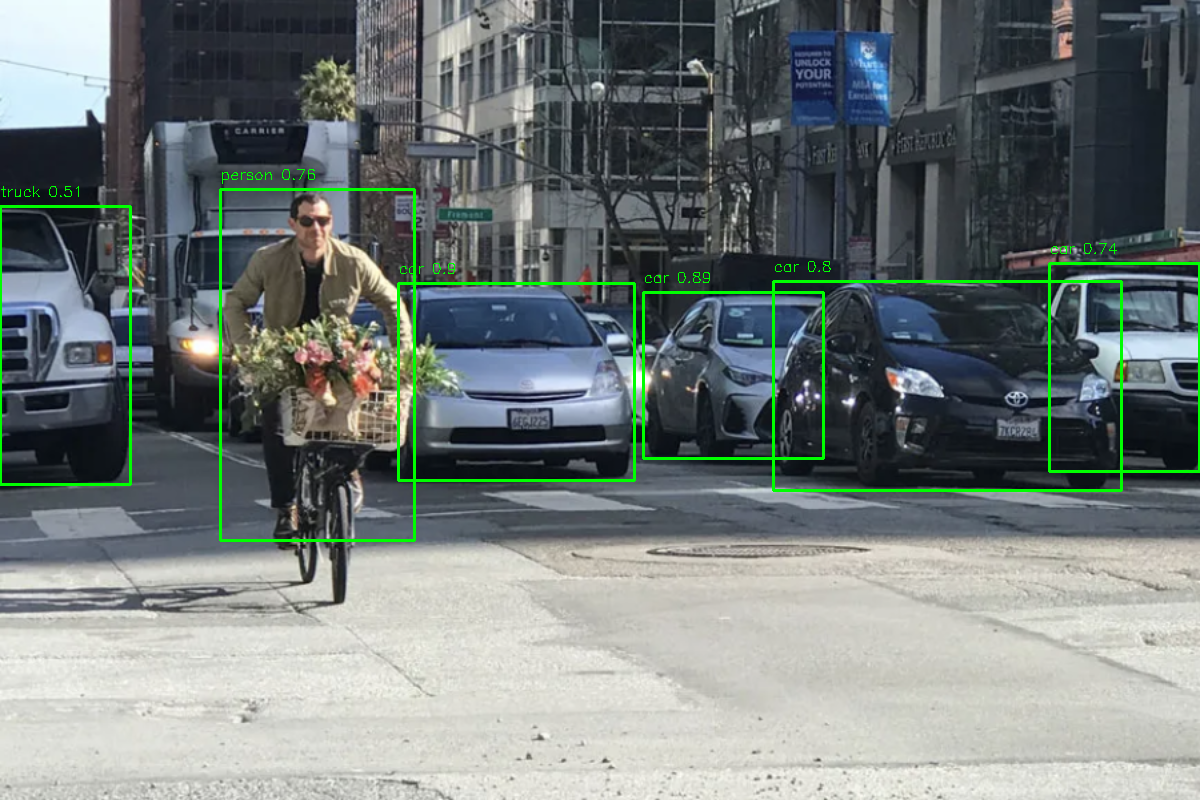

In [11]:
rgb = cv2.cvtColor(annot, cv2.COLOR_BGR2RGB)
display(Image.fromarray(rgb))

In [12]:
info_str = json.dumps(info, ensure_ascii=False, indent=2)
print("info:", info_str)

info: {
  "car": [
    {
      "location": [
        516,
        381
      ],
      "size": 46492,
      "bbox": [
        398,
        283,
        634,
        480
      ],
      "confidence": 0.9
    },
    {
      "location": [
        733,
        375
      ],
      "size": 29700,
      "bbox": [
        643,
        292,
        823,
        458
      ],
      "confidence": 0.89
    },
    {
      "location": [
        947,
        385
      ],
      "size": 72732,
      "bbox": [
        773,
        281,
        1121,
        490
      ],
      "confidence": 0.8
    },
    {
      "location": [
        1124,
        367
      ],
      "size": 30843,
      "bbox": [
        1049,
        263,
        1199,
        471
      ],
      "confidence": 0.74
    }
  ],
  "person": [
    {
      "location": [
        317,
        364
      ],
      "size": 67550,
      "bbox": [
        220,
        189,
        414,
        540
      ],
      "confidence": 0.76
    }
  ],
  "truck": [

In [14]:
question = "지금 보이는 물체들을 한줄로 간단히 설명해줘"
answer = chain.invoke({"info": info_str, "question": question})
# print("🤖 답변:", answer)

현재 보이는 객체는 카메라 화면 우측 중간에 트럭이 있고, 왼쪽 중하단에는 사람과 여러 대의 차가 있습니다.